# Optimising LightGBM for Fraud Detection

### Related Works

Chen, J. (2024). LightGBM model for detecting fraud in online financial transactions. *Highlights in Science, Engineering and Technology*, *93*, 363-371. https://doi.org/10.54097/xw0bng93

Iscan, C., Kumas, O., Akbulut, F. P., & Akbulut, A. (2023). Wallet-based transaction fraud prevention through lightgbm with the focus on minimizing false alarms. *IEEE Access*, *11*, 131465-131474. https://doi.org/10.1109/ACCESS.2023.3321666

- **Limitations identified in the studies:**
    - Utilised SMOTE to handle data imbalance, which creates synthetic samples that may not represent real-world distributions well
    - Mainly reported on accuracy or ROC-AUC, which can misrepresent model performance on imbalanced datasets

- **Our approach to overcoming these limitations:**
    - Compared the performance of three LightGBM models to assess the effects of encoding strategies and data balancing (see **details** below)
    - Included PR-AUC alongside other metrics for a more realistic evaluation on fraud cases

---

### Details

- **Models:**
    - **LightGBM** - relies on LightGBM’s internal handling of categorical features and imbalance
    - **LightGBM with external encoding** - tests how manual encoding (target and one-hot) influences model performance
    - **LightGBM with SMOTE** - tests whether oversampling improves results

- **External encoders (imported):**
    - Target encoder
    - One-hot encoder

- **Hyperparameter tuning:** all models used Optuna for optimisation
    - `RandomizedSearchCV` was initially used with 5-fold cross-validation, but the optimisation process was slow. Hence, we switched to Optuna for hyperparameter optimisation and `StratifiedKFold` for cross-validation, which achieved faster performance even with a larger number of trials. `StratifiedKFold` was selected because it preserves class distribution in each fold, making it useful for handling target imbalance

- **Reproducibility:** seed set to 1244

- **Metrics used for comparison:** precision, recall, f1, accuracy, ROC-AUC, PR-AUC

---

### Attributions and References

- **Code adapted from:**
    - LightGBM's Documentation: https://lightgbm.readthedocs.io/en/stable/index.html
    - Optuna Examples for LightGBM: https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py
    - SMOTE for Imbalanced Classification: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

- **Other references:**
    - Simple Explanation of LightGBM without Complicated Mathematics: https://medium.com/@soyoungluna/simple-explanation-of-lightgbm-without-complicated-mathematics-973998ec848f 

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')
X_test = joblib.load('../data/X_test.pkl')
y_test = joblib.load('../data/y_test.pkl')

In [3]:
X_train.head()

,region,dis,catg,mean_consommation_level_1,median_consommation_level_1,std_consommation_level_1,min_consommation_level_1,max_consommation_level_1,sum_consommation_level_1,std_consommation_level_3,...,active_days,consumption_mean,consumption_std,consumption_max,consumption_sum,max_min_ratio,monthly_consumption_std,avg_monthly_change,max_monthly_change,std_monthly_change
3584,301,62,11,657.541667,547.5,395.373679,0,2000,15781,0.0000,...,4739,674.208333,428.453435,2192,16181,2.192000e+09,360.196356,262.619048,655.300000,341.370073
3721,306,63,11,238.300000,217.0,97.485099,68,385,2383,0.0000,...,1099,238.300000,97.485099,385,2383,5.661765e+00,18.444173,22.875000,35.750000,18.208000
9570,303,62,11,876.200000,773.0,419.118360,520,1600,4381,148.0277,...,1029,1090.400000,613.182925,1940,5452,3.730769e+00,613.182925,920.750000,1252.000000,456.216597
9271,307,62,11,562.500000,574.0,188.705767,56,800,9000,0.0000,...,1830,574.937500,210.681266,999,9199,1.783929e+01,167.257301,232.066667,318.666667,86.434995
1328,103,69,11,97.428571,0.0,271.823761,0,1200,2046,0.0000,...,2666,134.571429,434.580438,1980,2826,1.980000e+09,151.949200,139.500000,327.500000,123.058116


In [4]:
X_train.dtypes

region                         category
dis                            category
catg                           category
mean_consommation_level_1       float64
median_consommation_level_1     float64
std_consommation_level_1        float64
min_consommation_level_1          int64
max_consommation_level_1          int64
sum_consommation_level_1          int64
std_consommation_level_3        float64
max_consommation_level_3          int64
sum_consommation_level_3          int64
mean_consommation_level_4       float64
std_consommation_level_4        float64
max_consommation_level_4          int64
sum_consommation_level_4          int64
sum_counter_coefficient           int64
mode_tarif_type                category
nunique_counter_statue            int64
mode_reading_remarque          category
nunique_reading_remarque          int64
num_invoices                      int64
active_days                       int64
consumption_mean                float64
consumption_std                 float64


In [5]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (9392, 32)
Test size: (2349, 32)


## LightGBM

Note: this takes approximately 2-3 minutes to run

In [6]:
# To handle imbalanced data
train_counts = y_train.value_counts()
scale_pos_weight = train_counts[0] / train_counts[1]

In [7]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 1244,
        'scale_pos_weight': scale_pos_weight, # scale_pos_weight performed better than is_unbalanced
        #'is_unbalanced': True,

        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    # Train model with these parameters 
    model = lgb.LGBMClassifier(**params) 
    
    # Evaluate with cross-validation 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    
    scores = cross_val_score( 
        model, X_train, y_train, 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1 
    ) 
    
    return scores.mean()

# Run optimisation
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1244))
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

[I 2025-11-02 17:38:30,832] A new study created in memory with name: no-name-3fb7af00-a60e-490a-852a-8e33cc7a1778


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-02 17:38:37,877] Trial 0 finished with value: 0.7077890627096358 and parameters: {'n_estimators': 685, 'learning_rate': 0.06514379596741586, 'num_leaves': 218, 'max_depth': 6, 'lambda_l1': 2.275198875246419e-07, 'lambda_l2': 5.51919428036466, 'feature_fraction': 0.9558031974207545, 'bagging_fraction': 0.5465838048593916, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 0 with value: 0.7077890627096358.
[I 2025-11-02 17:38:42,288] Trial 1 finished with value: 0.714135102526462 and parameters: {'n_estimators': 457, 'learning_rate': 0.02826949508765117, 'num_leaves': 51, 'max_depth': 8, 'lambda_l1': 1.2538749591830556, 'lambda_l2': 0.3405018618945788, 'feature_fraction': 0.99941422826621, 'bagging_fraction': 0.4344265605658815, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 0.714135102526462.
[I 2025-11-02 17:38:50,319] Trial 2 finished with value: 0.7242154341740911 and parameters: {'n_estimators': 588, 'learning_rate': 0.015461755397581928,

### Model Training and Evaluation

In [8]:
best_params = study.best_trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 1244,
    'scale_pos_weight': scale_pos_weight,
    #'is_unbalanced': True
})

lgbm = lgb.LGBMClassifier(**best_params, n_jobs=-1)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
y_pred_prob = lgbm.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test,  y_pred_prob)
print(f'ROC-AUC: {roc_auc:.4f}')

baseline_pr_auc = y_test.astype(int).mean() # reference point to identify the fraction of fraud in the test data
print(f'Baseline PR-AUC: {baseline_pr_auc:.4f}')

prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(rec, prec)
print(f'PR-AUC: {pr_auc:.4f}')

              precision    recall  f1-score   support

           0     0.9814    0.7039    0.8198      2246
           1     0.0989    0.7087    0.1736       103

    accuracy                         0.7041      2349
   macro avg     0.5401    0.7063    0.4967      2349
weighted avg     0.9427    0.7041    0.7915      2349

ROC-AUC: 0.7680
Baseline PR-AUC: 0.0438
PR-AUC: 0.1548


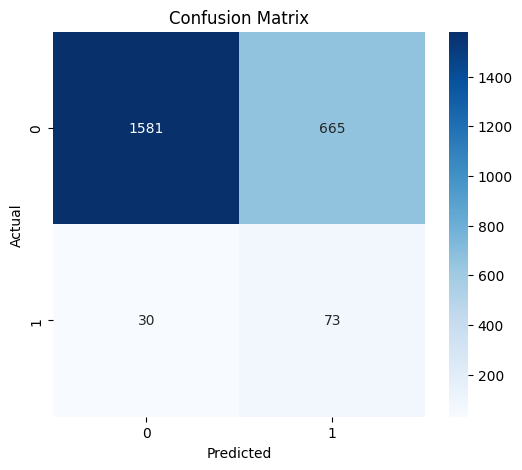

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

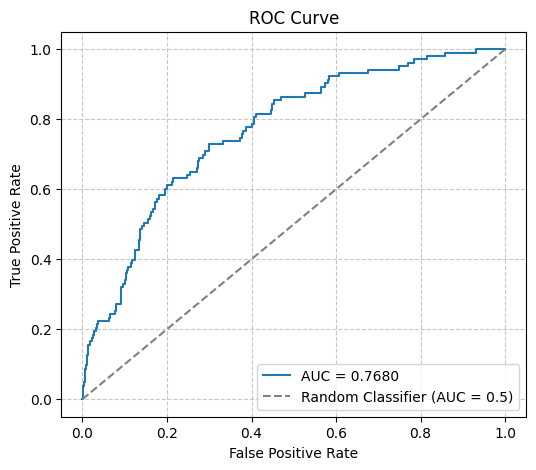

In [10]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--',color='grey', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

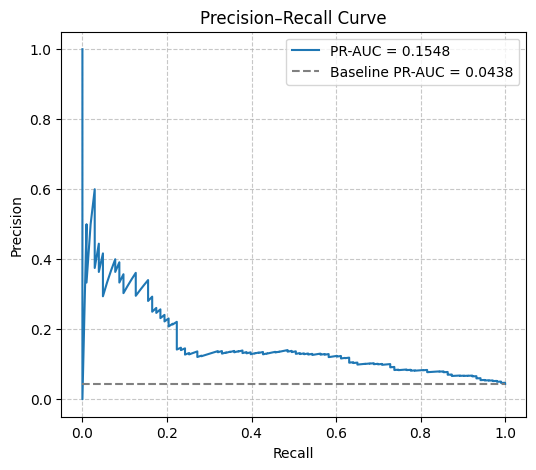

In [11]:
# Precision-recall curve
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR-AUC = {pr_auc:.4f}')
plt.hlines(baseline_pr_auc, 0, 1, color='grey', linestyles='--', label=f'Baseline PR-AUC = {baseline_pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

## LightGBM With External Encoding

Note: this takes approximately 2-3 minutes to run

In [12]:
# Import encoders
target_encoder = joblib.load('../data/target_encoder.pkl')
one_hot_encoder = joblib.load('../data/one_hot_encoder.pkl')

In [13]:
def objective_enc(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 1244,
        'scale_pos_weight': scale_pos_weight, # scale_pos_weight performed better than is_unbalanced
        #'is_unbalanced': True,

        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    # Train model with these parameters 
    model = lgb.LGBMClassifier(**params) 

    # Encode within a pipeline to avoid data leakage
    pipeline = Pipeline([
        ('target_encoder', target_encoder),
        ('one_hot_encoder', one_hot_encoder),
        ('model', model)
    ])
    
    # Evaluate with cross-validation 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    
    scores = cross_val_score( 
        pipeline, X_train, y_train, 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1 
    ) 
    
    return scores.mean()

# Run optimisation
if __name__ == '__main__':
    study_enc = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1244))
    study_enc.optimize(objective_enc, n_trials=30, show_progress_bar=True)

    print('Number of finished trials: {}'.format(len(study_enc.trials)))

    print('Best trial:')
    trial_enc = study_enc.best_trial

    print('  Value: {}'.format(trial_enc.value))

    print('  Params: ')
    for key, value in trial_enc.params.items():
        print('    {}: {}'.format(key, value))

[I 2025-11-02 17:40:26,690] A new study created in memory with name: no-name-49ee81d5-ee8c-4577-94cb-d11fd28ae2d1


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-02 17:40:32,441] Trial 0 finished with value: 0.7092491755276852 and parameters: {'n_estimators': 685, 'learning_rate': 0.06514379596741586, 'num_leaves': 218, 'max_depth': 6, 'lambda_l1': 2.275198875246419e-07, 'lambda_l2': 5.51919428036466, 'feature_fraction': 0.9558031974207545, 'bagging_fraction': 0.5465838048593916, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 0 with value: 0.7092491755276852.
[I 2025-11-02 17:40:36,364] Trial 1 finished with value: 0.7198452645936017 and parameters: {'n_estimators': 457, 'learning_rate': 0.02826949508765117, 'num_leaves': 51, 'max_depth': 8, 'lambda_l1': 1.2538749591830556, 'lambda_l2': 0.3405018618945788, 'feature_fraction': 0.99941422826621, 'bagging_fraction': 0.4344265605658815, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 0.7198452645936017.
[I 2025-11-02 17:40:44,857] Trial 2 finished with value: 0.7245955684326748 and parameters: {'n_estimators': 588, 'learning_rate': 0.01546175539758192

### Model Training and Evaluation (LightGBM With External Encoding)

In [14]:
best_params_enc = study_enc.best_trial.params
best_params_enc.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 1244,
    'scale_pos_weight': scale_pos_weight,
    #'is_unbalanced': True
})

lgbm_enc = lgb.LGBMClassifier(**best_params_enc, n_jobs=-1)

pipeline_enc = Pipeline([
        ('target_encoder', target_encoder),
        ('one_hot_encoder', one_hot_encoder),
        ('model', lgbm_enc)
])

pipeline_enc.fit(X_train, y_train)

y_pred_enc = pipeline_enc.predict(X_test)
y_pred_prob_enc = pipeline_enc.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_enc, digits=4))

roc_auc_enc = roc_auc_score(y_test,  y_pred_prob_enc)
print(f'ROC-AUC With Encoding: {roc_auc_enc:.4f}')

baseline_pr_auc = y_test.astype(int).mean() # reference point to identify the fraction of fraud in the test data
print(f'Baseline PR-AUC: {baseline_pr_auc:.4f}')

prec_enc, rec_enc, _ = precision_recall_curve(y_test, y_pred_prob_enc)
pr_auc_enc = auc(rec_enc, prec_enc)
print(f'PR-AUC With Encoding: {pr_auc_enc:.4f}')

              precision    recall  f1-score   support

           0     0.9805    0.7182    0.8291      2246
           1     0.1009    0.6893    0.1760       103

    accuracy                         0.7169      2349
   macro avg     0.5407    0.7037    0.5025      2349
weighted avg     0.9420    0.7169    0.8005      2349

ROC-AUC With Encoding: 0.7690
Baseline PR-AUC: 0.0438
PR-AUC With Encoding: 0.1615


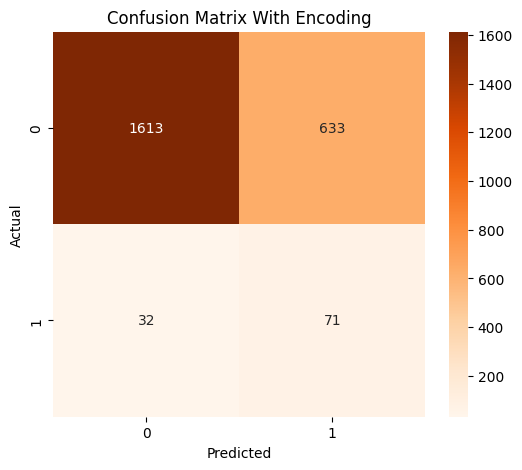

In [15]:
# Confusion matrix with encoding
cm_enc = confusion_matrix(y_test, y_pred_enc)
plt.figure(figsize=(6,5))
sns.heatmap(cm_enc, annot=True, fmt='d', cmap='Oranges')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With Encoding')
plt.show()

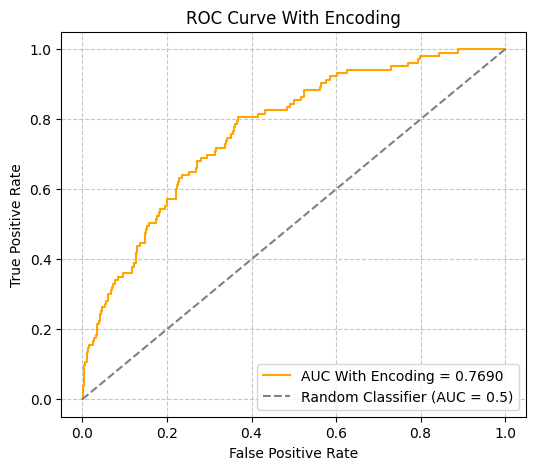

In [16]:
# ROC curve with encoding
fpr_enc, tpr_enc, _ = roc_curve(y_test, y_pred_prob_enc)
plt.figure(figsize=(6,5))
plt.plot(fpr_enc, tpr_enc,color='orange', label=f'AUC With Encoding = {roc_auc_enc:.4f}')
plt.plot([0,1],[0,1],'--',color='grey', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve With Encoding')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

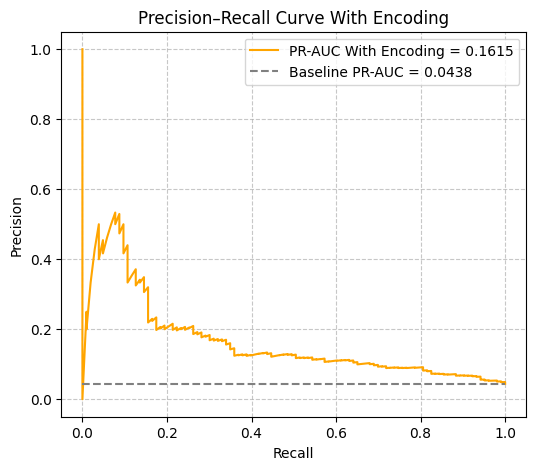

In [17]:
# Precision-recall curve with encoding
plt.figure(figsize=(6,5))
plt.plot(rec_enc, prec_enc, color='orange', label=f'PR-AUC With Encoding = {pr_auc_enc:.4f}')
plt.hlines(baseline_pr_auc, 0, 1, color='grey', linestyles='--', label=f'Baseline PR-AUC = {baseline_pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve With Encoding')
plt.legend()
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

## LightGBM With SMOTE

Note: this takes approximately 5-6 minutes to run

In [18]:
def objective_smote(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 1244,

        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    # Train model with these parameters 
    model = lgb.LGBMClassifier(**params) 

    # Apply SMOTE within a pipeline to avoid data leakage
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=1244)),
        ('model', model)
    ])
    
    # Evaluate with cross-validation 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    
    scores = cross_val_score( 
        pipeline, X_train, y_train, 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1 
    ) 
    
    return scores.mean()

# Run optimisation
if __name__ == '__main__':
    study_smote = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1244))
    study_smote.optimize(objective_smote, n_trials=30, show_progress_bar=True)

    print('Number of finished trials: {}'.format(len(study_smote.trials)))

    print('Best trial:')
    trial_smote = study_smote.best_trial

    print('  Value: {}'.format(trial_smote.value))

    print('  Params: ')
    for key, value in trial_smote.params.items():
        print('    {}: {}'.format(key, value))

[I 2025-11-02 17:42:04,946] A new study created in memory with name: no-name-029513b9-cf20-4de6-8855-d6cf114fa7d3


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-02 17:42:12,365] Trial 0 finished with value: 0.7106666494322119 and parameters: {'n_estimators': 685, 'learning_rate': 0.06514379596741586, 'num_leaves': 218, 'max_depth': 6, 'lambda_l1': 2.275198875246419e-07, 'lambda_l2': 5.51919428036466, 'feature_fraction': 0.9558031974207545, 'bagging_fraction': 0.5465838048593916, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 0 with value: 0.7106666494322119.
[I 2025-11-02 17:42:17,319] Trial 1 finished with value: 0.7244581454723233 and parameters: {'n_estimators': 457, 'learning_rate': 0.02826949508765117, 'num_leaves': 51, 'max_depth': 8, 'lambda_l1': 1.2538749591830556, 'lambda_l2': 0.3405018618945788, 'feature_fraction': 0.99941422826621, 'bagging_fraction': 0.4344265605658815, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 1 with value: 0.7244581454723233.
[I 2025-11-02 17:42:27,824] Trial 2 finished with value: 0.7328149634771364 and parameters: {'n_estimators': 588, 'learning_rate': 0.01546175539758192

### Model Training and Evaluation (LightGBM With SMOTE)

In [19]:
best_params_smote = study_smote.best_trial.params
best_params_smote.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 1244,
})

lgbm_smote = lgb.LGBMClassifier(**best_params_smote, n_jobs=-1)

pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=1244)),
    ('model', lgbm_smote)
])

pipeline_smote.fit(X_train, y_train)

y_pred_smote = pipeline_smote.predict(X_test)
y_pred_prob_smote = pipeline_smote.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_smote, digits=4))

roc_auc_smote = roc_auc_score(y_test,  y_pred_prob_smote)
print(f'ROC-AUC With SMOTE: {roc_auc_smote:.4f}')

baseline_pr_auc = y_test.astype(int).mean() # reference point to identify the fraction of fraud in the test data
print(f'Baseline PR-AUC: {baseline_pr_auc:.4f}')

prec_smote, rec_smote, _ = precision_recall_curve(y_test, y_pred_prob_smote)
pr_auc_smote = auc(rec_smote, prec_smote)
print(f'PR-AUC With SMOTE: {pr_auc_smote:.4f}')

              precision    recall  f1-score   support

           0     0.9573    0.9973    0.9769      2246
           1     0.3333    0.0291    0.0536       103

    accuracy                         0.9549      2349
   macro avg     0.6453    0.5132    0.5152      2349
weighted avg     0.9299    0.9549    0.9364      2349

ROC-AUC With SMOTE: 0.7407
Baseline PR-AUC: 0.0438
PR-AUC With SMOTE: 0.1284


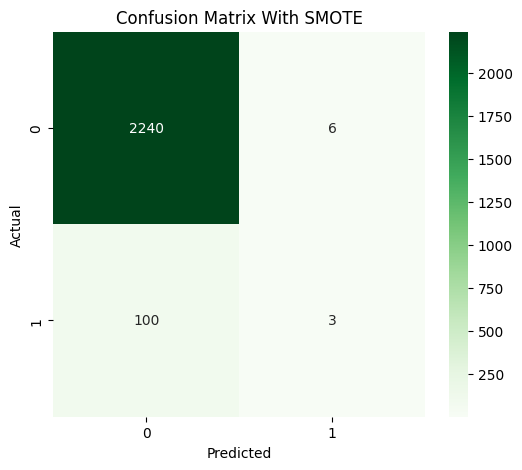

In [20]:
# Confusion matrix with SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6,5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix With SMOTE')
plt.show()

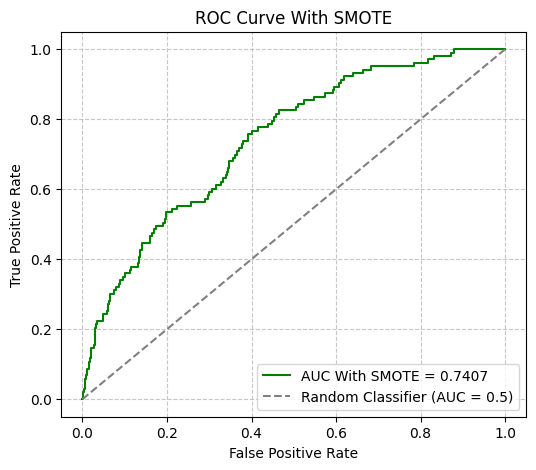

In [21]:
# ROC curve with SMOTE
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_prob_smote)
plt.figure(figsize=(6,5))
plt.plot(fpr_smote, tpr_smote, color='green', label=f'AUC With SMOTE = {roc_auc_smote:.4f}')
plt.plot([0,1],[0,1],'--',color='grey', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve With SMOTE')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

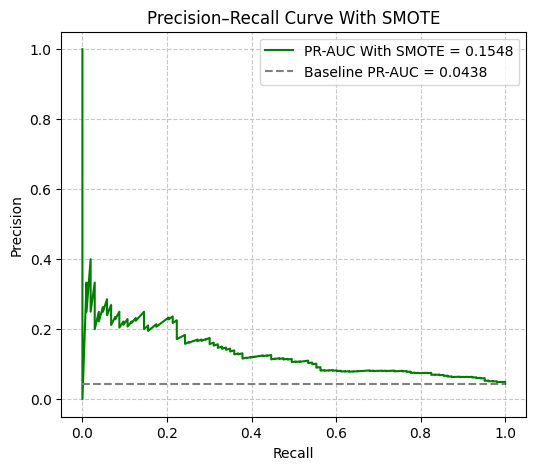

In [22]:
# Precision-recall curve with SMOTE
plt.figure(figsize=(6,5))
plt.plot(rec_smote, prec_smote, color='green', label=f'PR-AUC With SMOTE = {pr_auc:.4f}')
plt.hlines(baseline_pr_auc, 0, 1, color='grey', linestyles='--', label=f'Baseline PR-AUC = {baseline_pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve With SMOTE')
plt.legend()
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

## Comparison

In [23]:
results = []

def evaluate_model(name, y_test, y_pred, y_pred_prob):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(rec, prec)
    support = int(sum(y_test))  # number of positive samples in test set

    results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Support': support
    })

# Evaluate all models
evaluate_model('LightGBM', y_test, y_pred, y_pred_prob)
evaluate_model('LightGBM With Encoding', y_test, y_pred_enc, y_pred_prob_enc)
evaluate_model('LightGBM With SMOTE', y_test, y_pred_smote, y_pred_prob_smote)

# Creating the results table
results_df = pd.DataFrame(results)
results_df = results_df.round(4)
results_df = results_df.sort_values(by='Model').reset_index(drop=True)

# Styling
styled_table = (
    results_df.style
    .background_gradient(cmap='Blues', subset=['Precision', 'Recall', 'F1 Score', 'Accuracy', 'PR-AUC', 'ROC-AUC'])
    .format({
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1 Score': '{:.4f}',
        'Accuracy': '{:.4f}',
        'ROC-AUC': '{:.4f}',
        'PR-AUC': '{:.4f}',
        'Support': '{:,.0f}'
    })
    .set_table_styles([
        # Header row styling
        {'selector': 'thead th',
         'props': [
             ('font-size', '13px'),
             ('text-align', 'center'),
             ('background-color', '#1e3a8a'),
             ('color', 'white'),
             ('border-bottom', '2px solid #0f172a')
         ]},
        # Caption styling
        {'selector': 'caption',
         'props': [
             ('caption-side', 'top'),
             ('font-size', '15px'),
             ('font-weight', 'bold'),
             ('color', '#1e3a8a'),
             ('text-align', 'center')
         ]},
        # Support column neutral dark grey color
        {'selector': 'tbody td.col0, tbody td.col1, tbody td.col2, tbody td.col3, tbody td.col4, tbody td.col5, tbody td.col6',
         'props': [('text-align', 'center')]}
    ])
    .set_properties(subset=['Support'], **{
        'color': '#333',
        #'background-color': 'lightgrey',
        #'font-weight': 'bold',
        'text-align': 'center'
    })
    .set_caption('Model Comparison for Predicting Fraud')
)

display(styled_table)

,Model,Precision,Recall,F1 Score,Accuracy,ROC-AUC,PR-AUC,Support
0,LightGBM,0.0989,0.7087,0.1736,0.7041,0.7680,0.1548,103
1,LightGBM With Encoding,0.1009,0.6893,0.1760,0.7169,0.7690,0.1615,103
2,LightGBM With SMOTE,0.3333,0.0291,0.0536,0.9549,0.7407,0.1284,103


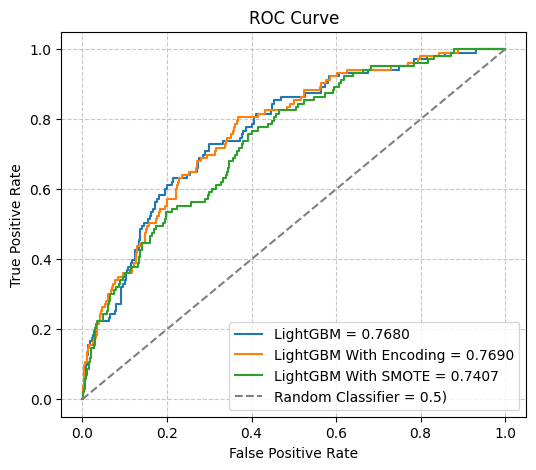

In [24]:
# Combined ROC curve
roc_data = [
    ('LightGBM', fpr, tpr, roc_auc),
    ('LightGBM With Encoding', fpr_enc, tpr_enc, roc_auc_enc),
    ('LightGBM With SMOTE', fpr_smote, tpr_smote, roc_auc_smote),
]

plt.figure(figsize=(6,5))

for name, fpr, tpr, auc_score in roc_data:
    plt.plot(fpr, tpr, label=f'{name} = {auc_score:.4f}')
    
plt.plot([0,1],[0,1],'--',color='grey', label='Random Classifier = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

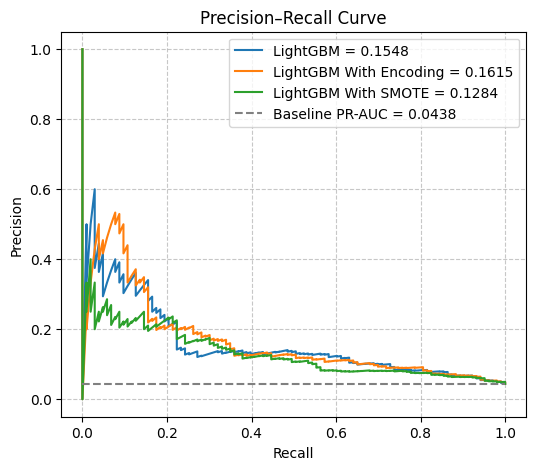

In [25]:
# Combined Precision-recall curve
pr_data = [
    ('LightGBM', rec, prec, pr_auc),
    ('LightGBM With Encoding', rec_enc, prec_enc, pr_auc_enc),
    ('LightGBM With SMOTE', rec_smote, prec_smote, pr_auc_smote)
]

plt.figure(figsize=(6,5))

for name, rec, prec, pr_score in pr_data:
    plt.plot(rec, prec, label=f'{name} = {pr_score:.4f}')
    
plt.hlines(baseline_pr_auc, 0, 1, color='grey', linestyles='--', label=f'Baseline PR-AUC = {baseline_pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

## Conclusion

**LightGBM with external encoding** was selected for further comparison, as it achieved the highest performance in 4 out of 6 metrics (f1, accuracy, ROC-AUC and PR-AUC), outperforming **LightGBM** (with internal handling), which was the second best performing model

**LightGBM** (with internal handling) performed slightly worse, which may be attributed to the presence of a high-cardinality feature, `region`. Further investigation would be needed to validate this hypothesis, but it is beyond the intended scope of this study

**LightGBM with SMOTE** showed the weakest performance, likely because the synthetic samples generated by SMOTE did not reflect real-world fraud patterns, leading to poorer generalisation and inflated noise in the training data

## Save Model

In [26]:
joblib.dump(lgbm_enc, '../data/lgbm_model.pkl')

['../data/lgbm_model.pkl']